In [71]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 

Import Data

In [33]:
#import data

df = pd.read_csv("data\produkt_tu_stunde_19480101_20211231_05906.txt", delimiter=';')
df

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,5906,1948010101,5,-0.3,90.0,eor
1,5906,1948010102,5,-0.3,89.0,eor
2,5906,1948010103,5,0.1,89.0,eor
3,5906,1948010104,5,0.5,91.0,eor
4,5906,1948010105,5,0.8,87.0,eor
...,...,...,...,...,...,...
648607,5906,2021123119,3,10.2,91.0,eor
648608,5906,2021123120,3,10.9,88.0,eor
648609,5906,2021123121,3,11.0,88.0,eor
648610,5906,2021123122,3,11.1,88.0,eor


Clean & harmonize data set

In [34]:
#remove unneeded data

df=df.drop(columns=['STATIONS_ID', 'QN_9', 'eor'])
df.head(2)

,MESS_DATUM,TT_TU,RF_TU
0,1948010101,-0.3,90.0
1,1948010102,-0.3,89.0


In [35]:
#rename MESS_DATUM in Date

df = df.rename(columns={"MESS_DATUM": "Date"})

In [36]:
#convert int to date

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.head(2)

,Date,TT_TU,RF_TU
0,1948-01-01 01:00:00,-0.3,90.0
1,1948-01-01 02:00:00,-0.3,89.0


In [37]:
#only last 21 years

df=df[df['Date'].dt.year >= 2001]
df

,Date,TT_TU,RF_TU
596004,2016-01-01 00:00:00,4.4,100.0
596005,2016-01-01 01:00:00,3.1,100.0
596006,2016-01-01 02:00:00,4.0,100.0
596007,2016-01-01 03:00:00,4.2,100.0
596008,2016-01-01 04:00:00,4.1,100.0
...,...,...,...
648607,2021-12-31 19:00:00,10.2,91.0
648608,2021-12-31 20:00:00,10.9,88.0
648609,2021-12-31 21:00:00,11.0,88.0
648610,2021-12-31 22:00:00,11.1,88.0


In [38]:
#remove leap years from dataset

df = df[~((df.Date.dt.month == 2) & (df.Date.dt.day == 29)) ]

In [39]:
#problem with -999 values

df.min()

Date     2016-01-01 00:00:00
TT_TU                   -999
RF_TU                   -999
dtype: object

In [40]:
#replace -999 values with nan

df = df.replace(-999, np.nan)
df.min()

Date     2016-01-01 00:00:00
TT_TU                    -13
RF_TU                     14
dtype: object

In [41]:
#count the nan values

df.apply(pd.isnull).sum()

Date       0
TT_TU    147
RF_TU    148
dtype: int64

In [42]:
#fill the nan values with the values forwoard

df=df.ffill(axis = 0)
df.apply(pd.isnull).sum()


Date     0
TT_TU    0
RF_TU    0
dtype: int64

Data set label & split

In [43]:
#create labeled data set for predictions in one year  -> 365*24

prediction_hours = (7*24)
df["Prediction_TT"]=df["TT_TU"].shift(-prediction_hours)
df["Prediction_RF"]=df["RF_TU"].shift(-prediction_hours)

df

,Date,TT_TU,RF_TU,Prediction_TT,Prediction_RF
596004,2016-01-01 00:00:00,4.4,100.0,5.5,78.0
596005,2016-01-01 01:00:00,3.1,100.0,5.9,77.0
596006,2016-01-01 02:00:00,4.0,100.0,5.9,84.0
596007,2016-01-01 03:00:00,4.2,100.0,5.5,80.0
596008,2016-01-01 04:00:00,4.1,100.0,4.8,82.0
...,...,...,...,...,...
648607,2021-12-31 19:00:00,10.2,91.0,NaN,NaN
648608,2021-12-31 20:00:00,10.9,88.0,NaN,NaN
648609,2021-12-31 21:00:00,11.0,88.0,NaN,NaN
648610,2021-12-31 22:00:00,11.1,88.0,NaN,NaN


In [44]:
#split the data in x und y axis

X = np.array(df[["TT_TU"]])
X = X[: len(df)-prediction_hours]

In [45]:
#create y values

y = np.array(df["Prediction_TT"])
y = y[:-prediction_hours]

In [46]:
#split the data in in train und test data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [47]:
#create variable with prediction space of 365*24 Values  multipli with 24 -> one day has 24 hours

prediction_hours_array = np.array(df[['TT_TU']])[-prediction_hours:]

Support Vector Regression

In [48]:
#from sklearn.svm import SVR

#Support Vector Regression with radial basis function

svr_rbf = SVR(kernel="rbf", C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [49]:
#score of the model

model_test = svr_rbf.score(X_test, y_test)
print("Model Score: ", model_test)

Model Score:  0.6287512948527916


Visualization of the result

In [50]:
#print final prediction 

svm_prediction = svr_rbf.predict(prediction_hours_array)
print(svm_prediction)

print()


print(df["TT_TU"].tail(prediction_hours))

[ 6.78169115  6.52637346  6.40549757  6.2904962   6.65213381  6.78169115
  6.65213381  7.04758833  6.65213381  6.78169115  6.78169115  5.34298035
  5.28378163  5.25033198  5.17526731  4.95174232  4.9988108   4.81219514
  4.6103644   4.51246108  4.51246108  4.48215469  4.45215466  4.48215469
  4.35787071  4.32299138  4.15384899  4.15384899  4.10314306  4.10314306
  4.10314306  4.04919858  3.99236933  4.10314306  4.24496442  4.42185632
  4.57613591  4.6103644   4.64658076  4.6103644   4.54362855  4.57613591
  4.57613591  4.51246108  4.51246108  4.51246108  4.51246108  4.54362855
  4.6103644   4.68492607  4.68492607  4.85790071  5.17526731  5.52669703
  5.64696126  5.69954666  6.08139072  6.40549757  7.4464199  10.1013507
 10.1013507   9.55832379  9.18957392  9.00967621  8.46465992  8.46465992
  8.05333814  8.26666112  8.16209643  7.82268272  7.70094303  7.82268272
  7.4464199   8.05333814  8.05333814  8.26666112  8.46465992  8.36736384
  8.16209643  8.16209643  8.05333814  8.05333814  9.

In [79]:
#add svm_prediction to dataframe 2 for plot

#create a copy of df to df2
df2 = pd.DataFrame(columns= ["Date"])
df2['Date'] = df['Date']
df2['TT_TU'] = df['TT_TU']
df2['RF_TU'] = df['RF_TU']
df2['Prediction_TT'] = df['Prediction_TT']
df2['Prediction_RF'] = df['Prediction_RF']
df2 = df2.reset_index(drop=True)
df2['Date'] = pd.to_datetime(df2['Date'])

#create array with nan values
x= (len(df2)- prediction_hours)
a = np.empty([x])
a[:] = np.nan

#add final prediction to nan array
a = np.append(a,svm_prediction)

#add final array to dataframe2 for plot
df2.loc[:,'svm_prediction'] = pd.Series(a)
df2

52560
52560


,Date,TT_TU,RF_TU,Prediction_TT,Prediction_RF,svm_prediction
0,2016-01-01 00:00:00,4.4,100.0,5.5,78.0,NaN
1,2016-01-01 01:00:00,3.1,100.0,5.9,77.0,NaN
2,2016-01-01 02:00:00,4.0,100.0,5.9,84.0,NaN
3,2016-01-01 03:00:00,4.2,100.0,5.5,80.0,NaN
4,2016-01-01 04:00:00,4.1,100.0,4.8,82.0,NaN
...,...,...,...,...,...,...
52555,2021-12-31 19:00:00,10.2,91.0,NaN,NaN,9.926409
52556,2021-12-31 20:00:00,10.9,88.0,NaN,NaN,10.492311
52557,2021-12-31 21:00:00,11.0,88.0,NaN,NaN,10.563084
52558,2021-12-31 22:00:00,11.1,88.0,NaN,NaN,10.632380


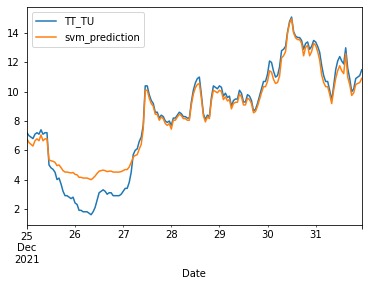

In [84]:
#plot prediction over total value
#scope in days for range options

scope = 0
xy = pd.to_datetime('2021-12-31') - pd.DateOffset(days=((prediction_hours/24)-1) + scope)

df3=df2[df2['Date'] >= xy]
df3.plot(x="Date", y=["TT_TU", "svm_prediction"], kind="line")